# Experiment 2 Validation - Logistic Regression + Reweighing

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Step 0: Setup Environment
!pip install aif360 shap scikit-learn pandas matplotlib seaborn joblib openpyxl --quiet


In [19]:
# Step 1: Imports
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from aif360.datasets import StandardDataset
from aif360.metrics import ClassificationMetric

In [20]:
# Step 2: Define Paths and Load Model
MODEL_PATH = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/trained models/lr_reweighing.pkl'
DATASET_PATH = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation dataset/TestData set.xlsx'
RESULTS_DIR = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation Results'

print('Loading Experiment 2 model (Reweighing)...')
saved_obj = joblib.load(MODEL_PATH)
if isinstance(saved_obj, dict):
    clf = saved_obj['model']
else:
    clf = saved_obj
print('Model loaded successfully!')

Loading Experiment 2 model (Reweighing)...
Model loaded successfully!


In [21]:
# Step 3: Preprocess Test Dataset (6 features only)
def preprocess_testdata(df):
    print('\\n=== Preprocessing TestData set.xlsx ===')
    print(f'Original shape: {df.shape}')
    print(f'Columns: {df.columns.tolist()}')
    df = df.copy()

    processed = pd.DataFrame()

    # 1. Annual income
    if 'annual_inc' in df.columns:
        scaler = StandardScaler()
        processed['annual_inc'] = scaler.fit_transform(df[['annual_inc']].fillna(df['annual_inc'].median())).ravel()
    else:
        processed['annual_inc'] = 0

    # 2. Term
    if 'term' in df.columns:
        le = LabelEncoder()
        processed['term'] = le.fit_transform(df['term'].astype(str))
    else:
        processed['term'] = 0

    # 3. Grade
    if 'grade' in df.columns:
        le = LabelEncoder()
        processed['grade'] = le.fit_transform(df['grade'].astype(str))
    else:
        processed['grade'] = 0

    # 4. Home ownership
    if 'home_ownership' in df.columns:
        le = LabelEncoder()
        processed['home_ownership'] = le.fit_transform(df['home_ownership'].astype(str))
    else:
        processed['home_ownership'] = 0

    # 5. Purpose
    if 'purpose' in df.columns:
        le = LabelEncoder()
        processed['purpose'] = le.fit_transform(df['purpose'].astype(str))
    else:
        processed['purpose'] = 0

    # 6. Loan amount (extra feature to match training schema)
    if 'loan_amnt' in df.columns:
        scaler = StandardScaler()
        processed['loan_amnt'] = scaler.fit_transform(df[['loan_amnt']].fillna(df['loan_amnt'].median())).ravel()
    else:
        processed['loan_amnt'] = 0

    # 7. Protected attribute
    if 'zip_code' in df.columns:
        le = LabelEncoder()
        processed['zip_code'] = le.fit_transform(df['zip_code'].astype(str))
    elif 'age' in df.columns:
        median_age = df['age'].median()
        processed['zip_code'] = (df['age'] >= median_age).astype(int)
    else:
        processed['zip_code'] = 0

    # Target encoding
    if 'loan_status' in df.columns:
        status_map = {'Fully Paid': 1, 'Current': 1, 'Charged Off': 0, 'Default': 0,
                      'Late (31-120 days)': 0, 'Late (16-30 days)': 0, 'In Grace Period': 0}
        df['loan_status_mapped'] = df['loan_status'].map(status_map).fillna(0).astype(int)
        processed['loan_status'] = df['loan_status_mapped']
    else:
        processed['loan_status'] = 1

    processed = processed.dropna()
    print(f'Processed shape: {processed.shape}')
    print(f'Features: {[col for col in processed.columns if col != "loan_status"]}')
    return processed

In [22]:

# Step 4: Metric Functions
def calculate_performance_metrics(y_true, y_pred, y_prob):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1': f1_score(y_true, y_pred, zero_division=0),
        'AUC_ROC': roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else 0.0
    }

def calculate_fairness_metrics(aif_data, pred_dataset, privileged_groups, unprivileged_groups):
    metric = ClassificationMetric(aif_data, pred_dataset,
                                  unprivileged_groups=unprivileged_groups,
                                  privileged_groups=privileged_groups)
    return {
        'SPD': metric.statistical_parity_difference(),
        'DI': metric.disparate_impact(),
        'EOD': metric.equal_opportunity_difference(),
        'AOD': metric.average_odds_difference(),
        'Bias_Amplification': metric.between_group_generalized_entropy_index(),
        'Theil_Index': metric.theil_index()
    }

def calculate_explainability_metrics(model, X, y, feature_names):
    try:
        explainer = shap.LinearExplainer(model, X)
        shap_values = explainer.shap_values(X)
        shap_std = np.std(shap_values, axis=0)
        shap_mean = np.abs(np.mean(shap_values, axis=0))
        stability = np.mean(shap_std / (shap_mean + 1e-10))
        total_importance = np.sum(np.abs(shap_values))
        top_5_importance = np.sum(np.abs(shap_values)[:, np.argsort(np.abs(shap_values).mean(0))[-5:]])
        coverage = top_5_importance / total_importance if total_importance > 0 else 0
        y_pred = model.predict(X)
        consistency = accuracy_score(y, y_pred)
        return {'SHAP_Stability': stability, 'Explanation_Coverage': coverage, 'Counterfactual_Validity': consistency}, shap_values
    except Exception as e:
        print(f'Warning: SHAP calculation failed: {e}')
        return {'SHAP_Stability': np.nan, 'Explanation_Coverage': np.nan, 'Counterfactual_Validity': np.nan}, None



In [23]:
# Step 5: Validation Function
def validate_on_testdata(df_processed, model):
    privileged_groups = [{'zip_code': 1}]
    unprivileged_groups = [{'zip_code': 0}]

    aif_data = StandardDataset(
        df_processed,
        label_name='loan_status',
        favorable_classes=[1],
        protected_attribute_names=['zip_code'],
        privileged_classes=[[1]]
    )

    X = aif_data.features
    y = aif_data.labels.ravel()

    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]

    print('\\nPERFORMANCE METRICS')
    perf = calculate_performance_metrics(y, y_pred, y_prob)
    for k, v in perf.items():
        print(f'{k}: {v:.4f}')

    print('\\nClassification Report:')
    print(classification_report(y, y_pred, zero_division=0))

    print('\\nFAIRNESS METRICS')
    pred_dataset = aif_data.copy()
    pred_dataset.labels = y_pred.reshape(-1, 1)
    fair = calculate_fairness_metrics(aif_data, pred_dataset, privileged_groups, unprivileged_groups)
    for k, v in fair.items():
        print(f'{k}: {v:.4f}')

    print('\\nEXPLAINABILITY METRICS')
    explain, shap_values = calculate_explainability_metrics(model, X, y, aif_data.feature_names)
    for k, v in explain.items():
        print(f'{k}: {v:.4f}')

    if shap_values is not None:
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, pd.DataFrame(X, columns=aif_data.feature_names), show=False)
        plt.title('SHAP Summary - Experiment 2 (Reweighing)')
        plt.tight_layout()
        plt.savefig(f'{RESULTS_DIR}/shap_exp2_testdata.png', dpi=150)
        plt.show()

    return {**perf, **fair, **explain}



\n=== Preprocessing TestData set.xlsx ===
Original shape: (5001, 151)
Columns: ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 

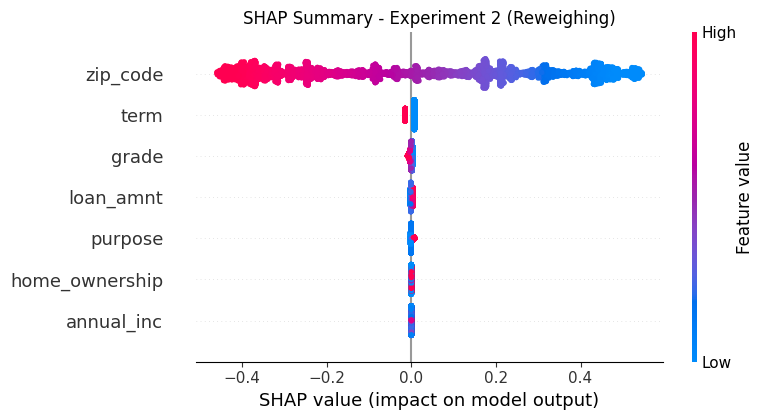

In [24]:
# Step 6: Run Validation
test_df = pd.read_excel(DATASET_PATH)
test_processed = preprocess_testdata(test_df)
results = validate_on_testdata(test_processed, clf)




In [25]:
# Step 7: Save Results
results_df = pd.DataFrame([results])
out_path = f'{RESULTS_DIR}/experiment2_validation_results_testdata.csv'
results_df.to_csv(out_path, index=False)
print(f'\\nResults saved to: {out_path}')

\nResults saved to: /content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation Results/experiment2_validation_results_testdata.csv
